In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
az.style.use("arviz-white")

In [4]:
data = bmb.load_data("sleepstudy")
model = bmb.Model("Reaction ~ 1 + Days + (Days | Subject)", data)
idata = model.fit(draws=1500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, Days, 1|Subject_sigma, 1|Subject_offset, Days|Subject_sigma, Days|Subject_offset, Reaction_sigma]


Sampling 2 chains for 1_000 tune and 1_500 draw iterations (2_000 + 3_000 draws total) took 22 seconds.


In [6]:
model.predict_2(idata)

In [7]:
model.predict_2(idata, kind="pps")

In [8]:
def plot_data(data):
    fig, axes = plt.subplots(2, 9, figsize=(16, 7.5), sharey=True, sharex=True, dpi=300)
    fig.subplots_adjust(left=0.075, right=0.975, bottom=0.075, top=0.925, wspace=0.03)

    axes_flat = axes.ravel()

    for i, subject in enumerate(data["Subject"].unique()):
        ax = axes_flat[i]
        idx = data.index[data["Subject"] == subject].tolist()
        days = data.loc[idx, "Days"].values
        reaction = data.loc[idx, "Reaction"].values

        # Plot observed data points
        ax.scatter(days, reaction, color="C0", ec="black", alpha=0.7)

        # Add a title
        ax.set_title(f"Subject {subject}", fontsize=14)

    ax.xaxis.set_ticks([0, 2, 4, 6, 8])
    fig.text(0.5, 0.02, "Days", fontsize=14)
    fig.text(0.03, 0.5, "Reaction time (ms)", rotation=90, fontsize=14, va="center")

    return axes

/tmp/ipykernel_30167/1199577939.py:3: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(left=0.075, right=0.975, bottom=0.075, top=0.925, wspace=0.03)


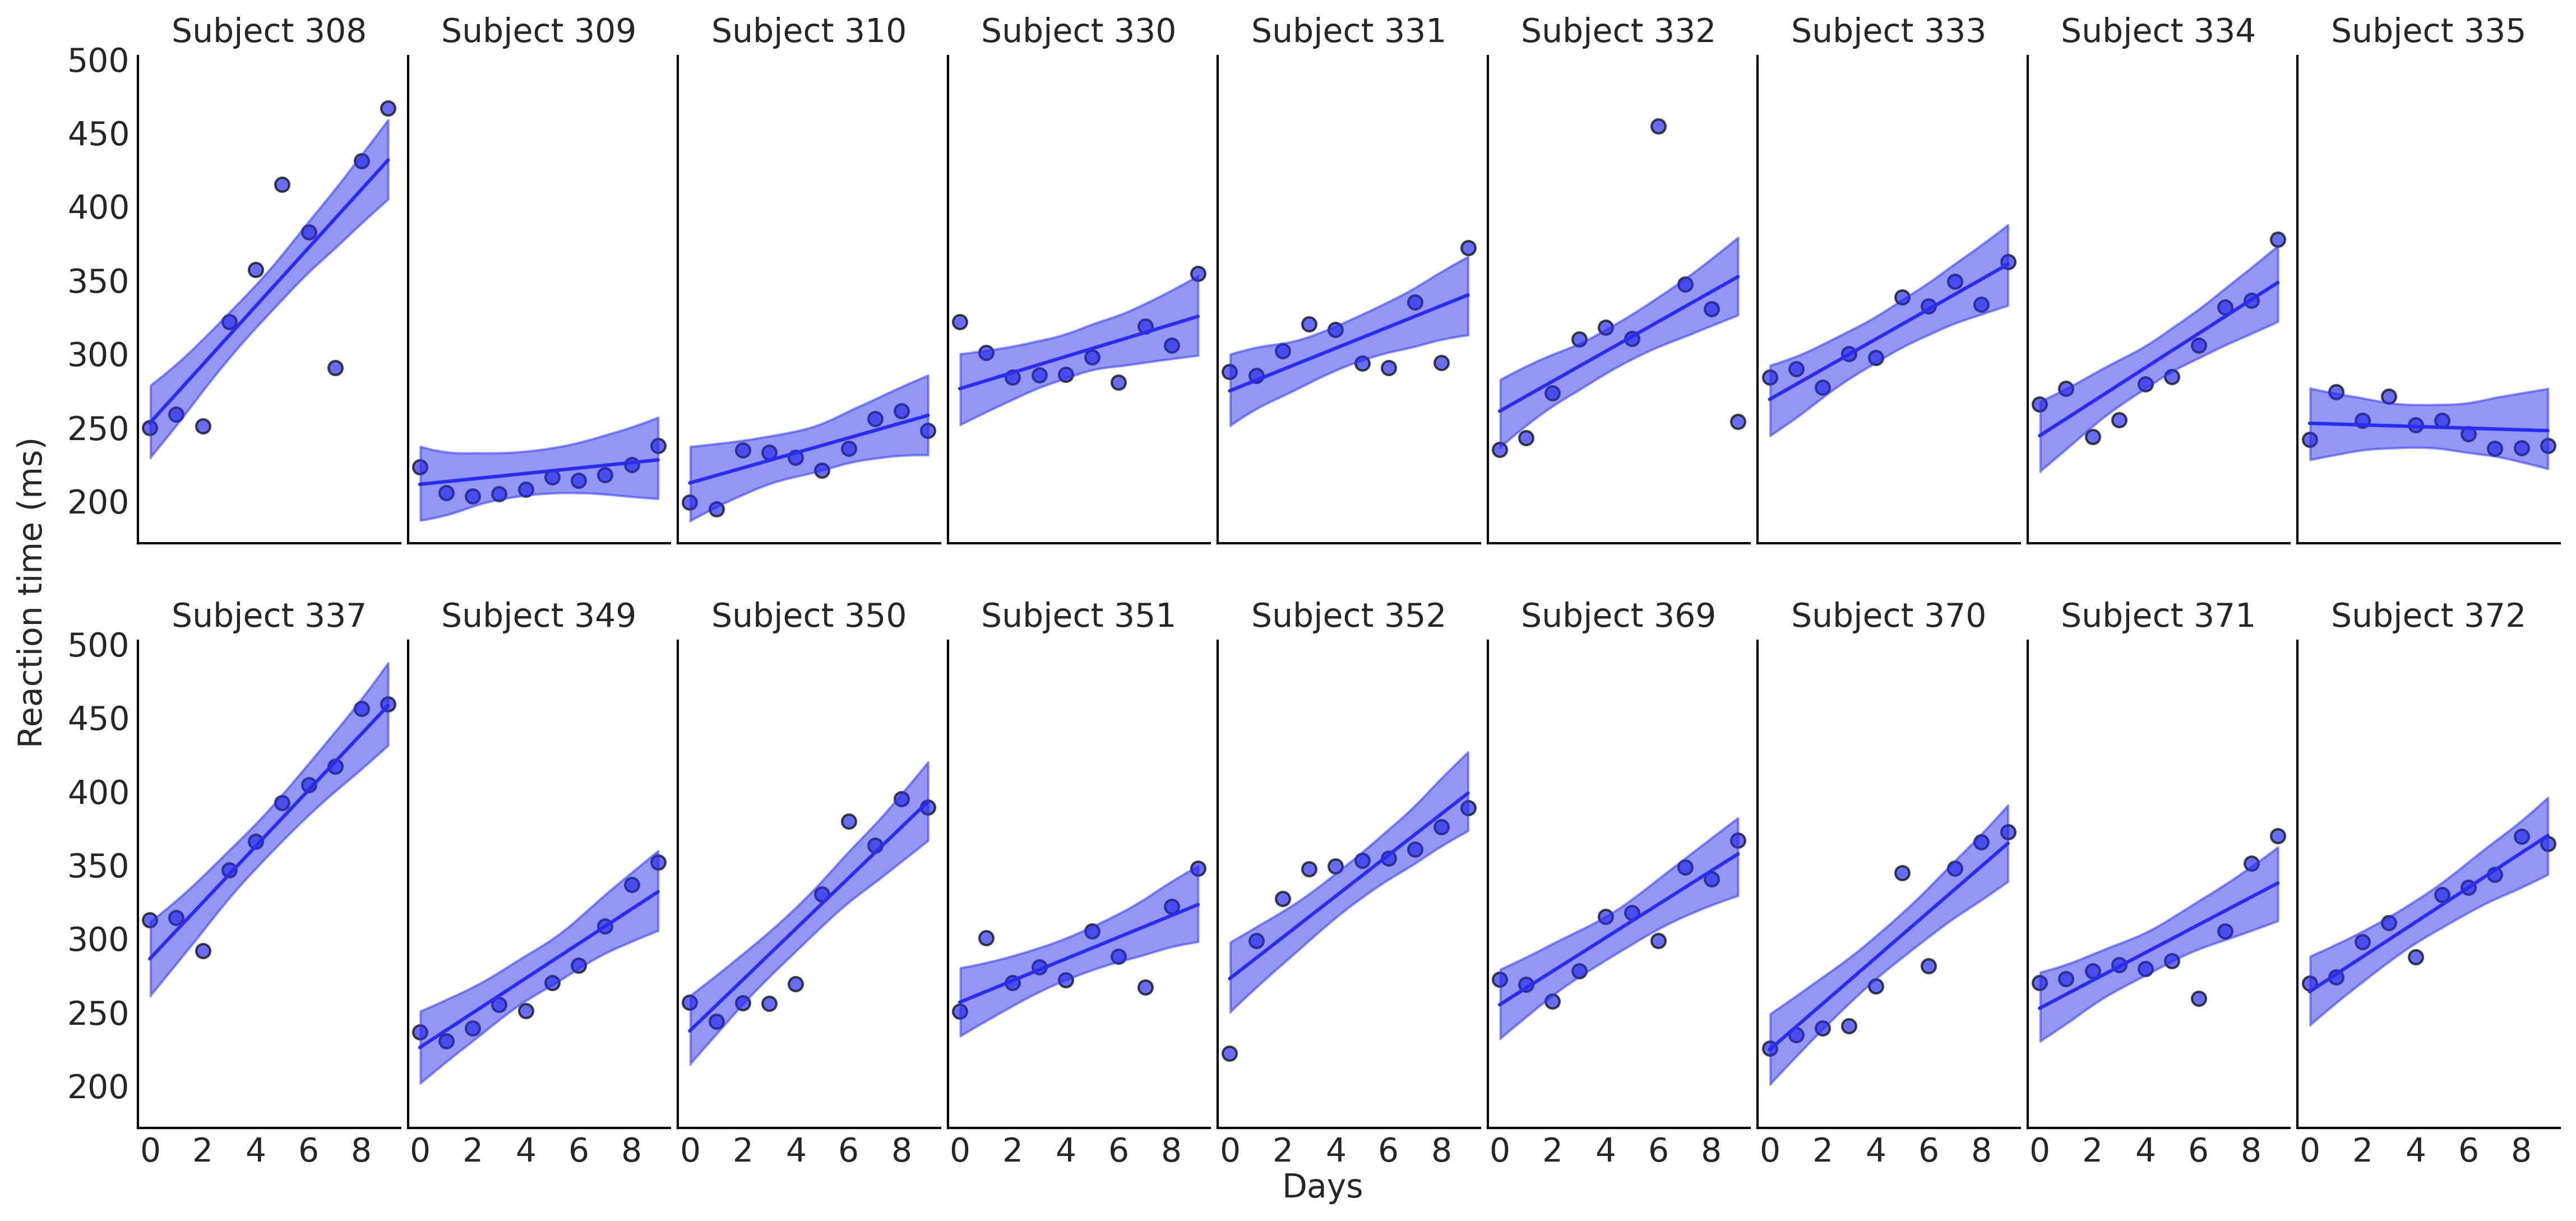

In [10]:
# Plot the data
axes = plot_data(data)

axes_flat = axes.ravel()

# Take the posterior of the mean reaction time
#reaction_mean = y_hat.stack(samples=("draw", "chain")).values
reaction_mean = idata.posterior["Reaction_mean"].stack(samples=("draw", "chain")).to_numpy()

for i, subject in enumerate(data["Subject"].unique()):
    ax = axes_flat[i]
    idx = data.index[data["Subject"]== subject].tolist()
    days = data.loc[idx, "Days"].values
    
    # Plot highest density interval / credibility interval
    az.plot_hdi(days, reaction_mean[idx].T[np.newaxis], color="C0", ax=ax)
    
    # Plot mean regression line
    ax.plot(days, reaction_mean[idx].mean(axis=1), color="C0")

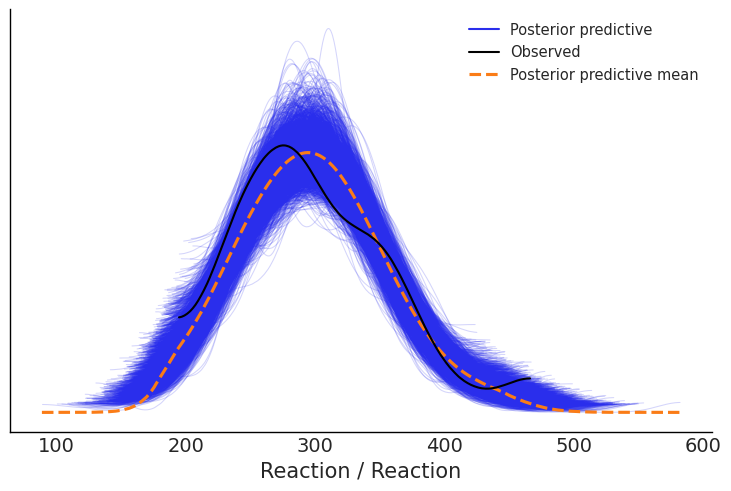

In [11]:
az.plot_ppc(idata);